In [1]:
from helper import generate_2d_ising_observable_data, plot_error_vs_depth

Define parameters

In [2]:
J = 1
g = 0.5
dt = 0.1
num_rows = 3
num_cols = 4
pad = 2

thresholds = [0]
max_bonds = [8, 16, 32]
timesteps_list = range(1, 55, 5)

In [3]:
results = generate_2d_ising_observable_data(num_rows, num_cols, J, g, dt, pad, thresholds, max_bonds, timesteps_list)

Max Bond 8
TDVP Max Bond 4
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8
TDVP Max Bond 8
TEBD Max Bond 8
Max Bond 16
TDVP Max Bond 4
TEBD Max Bond 11
TDVP Max Bond 16
TEBD Max Bond 16
TDVP Max Bond 16
TEBD Max Bond 16
TDVP Max Bond 16
TEBD Max Bond 16
TDVP Max Bond 16
TEBD Max Bond 16
TDVP Max Bond 16
TEBD Max Bond 16
TDVP Max Bond 16
TEBD Max Bond 16
TDVP Max Bond 16
TEBD Max Bond 16
TDVP Max Bond 16
TEBD Max Bond 16
TDVP Max Bond 16
TEBD Max Bond 16
TDVP Max Bond 16
TEBD Max Bond 16
Max Bond 32
TDVP Max Bond 4
TEBD Max Bond 11
TDVP Max Bond 32
TEBD Max Bond 32
TDVP Max Bond 32
TEBD Max Bond 32
TDVP Max Bond 32
TEBD Max Bond 32
TDVP Max Bond 32
TEBD Max Bond 32
TDVP Max Bond 32
TEBD Max Bond 32
TDVP Max Bond 32
TEBD Max Bond 32
TDV

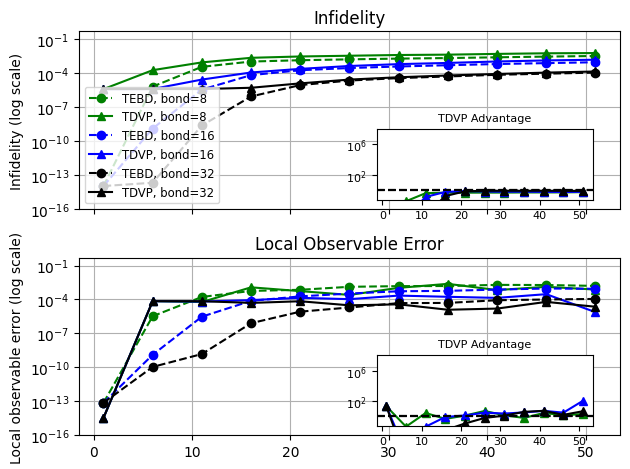

In [4]:
plot_error_vs_depth(results, max_bonds)